In [1]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-BERT.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Drop the first column (if it's an unwanted index column)
df = df.drop(df.columns[0], axis=1)

# Display the column names
df.columns.tolist()


Mounted at /content/drive


['price',
 'address',
 'descrip',
 'listed_since',
 'zip_code',
 'size',
 'year',
 'living_area',
 'kind_of_house',
 'building_type',
 'num_of_rooms',
 'num_of_bathrooms',
 'layout',
 'energy_label',
 'insulation',
 'heating',
 'ownership',
 'exteriors',
 'parking',
 'date_list',
 'last_ask_price',
 'last_ask_price_m2',
 'city',
 'log_id',
 'num of tokens per descrip',
 'descrip_en',
 'numerical_price',
 'numerical_price_per_m2',
 'tag',
 'house_category',
 'living_area_float',
 'size_float',
 'zip_code_4_digits',
 'postcode',
 'latitude',
 'longitude',
 'embeddings']

In [2]:
# Assuming df is your original DataFrame
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval


# Convert the 'ada_embedding_eng' column to a list of arrays if they are not already
df["embeddings"] = df["embeddings"].apply(literal_eval).apply(np.array)

x = df["embeddings"]
y = df['numerical_price']


###### deleting original dataframe for memory purpose ####
del df

In [3]:
x = x.apply(pd.Series)

# First split: separate out a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]

In [4]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Ensure y_train and y_test are 1D arrays
# This step is only necessary if y_train or y_test are not already 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Check the shapes again after any necessary adjustments
print("Adjusted y_train shape:", y_train.shape)
print("Adjusted y_test shape:", y_test.shape)


Adjusted y_train shape: (10000,)
Adjusted y_test shape: (14403,)


In [5]:
!pip install optuna
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_rf(trial):
    # Parameters
    max_depth = trial.suggest_int("max_depth", 2, 50, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt',])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 25, step=2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 25, step=2)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    rf_params = dict(max_depth=max_depth, n_estimators=n_estimators,
                     max_features=max_features, min_samples_leaf=min_samples_leaf,
                     min_samples_split=min_samples_split, bootstrap=bootstrap)

    clf_rf_opt = RandomForestRegressor(**rf_params, n_jobs=-1)

    # StandardScaler for y
    scaler = StandardScaler()

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Scaling y_train
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()

        # Fitting the model
        clf_rf_opt.fit(X_train_fold, y_train_scaled)

        # Predicting and inverse transformation
        y_pred_scaled = clf_rf_opt.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # R2 Score
        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return float(np.mean(r2_scores))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.4 MB/s eta 0:00:00


In [6]:
study_rf = optuna.create_study(directions=['maximize'])
study_rf.optimize(Objective_rf, n_trials=50)

[I 2024-01-06 23:23:25,932] A new study created in memory with name: no-name-e0a63a44-cb24-4dea-a4a5-ba2c2ac41a35
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 25] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 24].
  warnings.warn(
[I 2024-01-06 23:25:01,202] Trial 0 finished with value: 0.11985204268741032 and parameters: {'max_depth': 6, 'n_estimators': 350, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 24, 'bootstrap': False}. Best is trial 0 with value: 0.11985204268741032.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 25] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 24].
  warnings.warn(
[I 2024-01-06 23:27:19,402] Trial 1 finished with value: 0.10388686660794573 and parameters: {'max_depth': 5, 'n_estimators': 700, 'max_features': 'log2', 'min_

<ipython-input-7-934d0b211bde>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

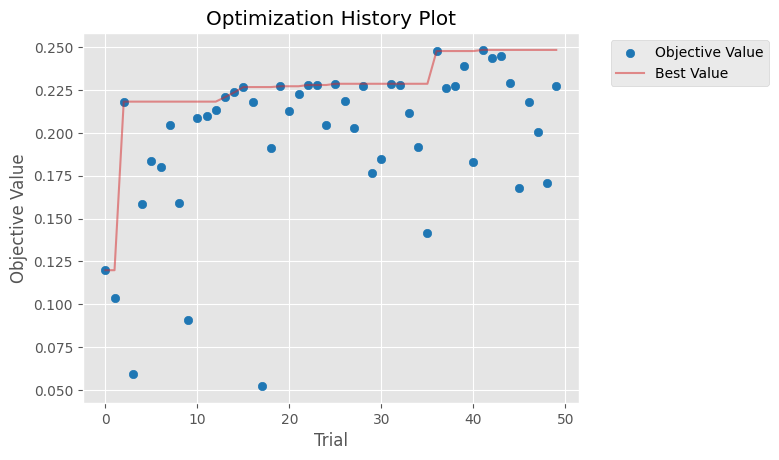

In [7]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

<ipython-input-8-b23cac3d6009>:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)
<ipython-input-8-b23cac3d6009>:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)
<ipython-input-8-b23cac3d6009>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_rf)


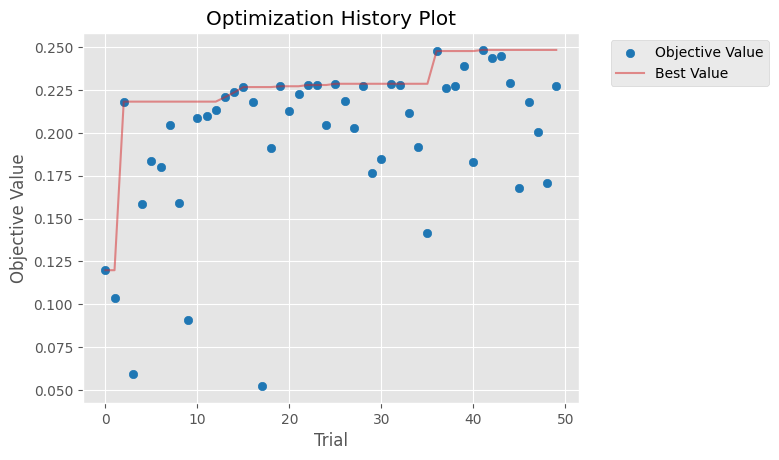

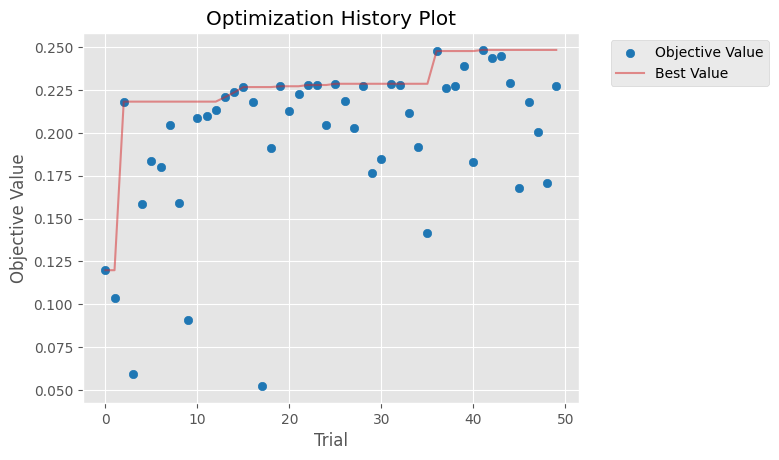

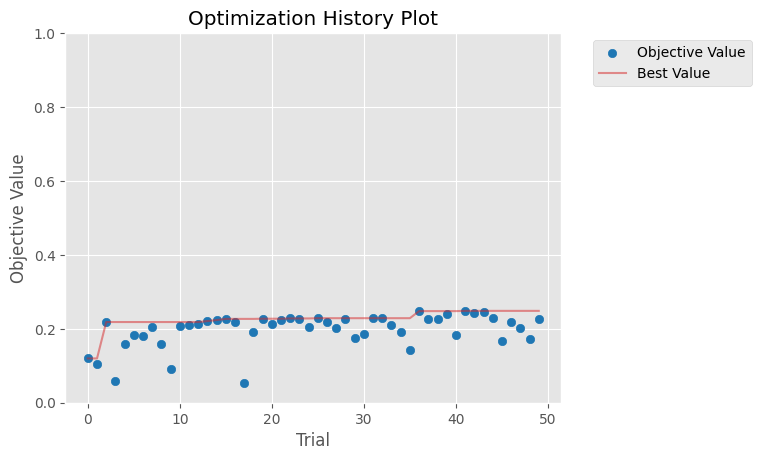

In [8]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

optuna.visualization.matplotlib.plot_optimization_history(study_rf)
optuna_matplotlib.plot_optimization_history(study_rf)

plt.ylim(0, 1)

# Show the plot
plt.show()